# Lecture 3: Matvecs and matmuls, memory hierarchy, Strassen algorithm

## Recap of the previous lectures

- Floating point arithmetics and related issues
- Stable algorithms: backward and forward stability
- Most important matrix norms: spectral and Frobenius
- Unitary matrices preserve these norms
- There are two "basic" classes of unitary matrices: Householder and Givens matrices

## Examples of peak performance

**Flops** –– floating point operations per second.

Giga = $2^{30} \approx 10^9$,  
Tera = $2^{40} \approx 10^{12}$,      
Peta = $2^{50} \approx 10^{15}$,       
Exa = $2^{60} \approx 10^{18}$ 

What is the **peak perfomance** of:

1. Modern CPU
2. Modern GPU
3. Largest supercomputer of the world? 

### Clock frequency of CPU vs. performance in flops

FLOPS = sockets * (cores per socket) * (number of clock cycles per second) * (number of floating point operations per cycle).

- Typically sockets = 1
- Number of cores is typically 2 or 4
- Number of ticks per second is familiar clock frequency
- Number of floating point operations per tick depends on the particular CPU


1. Modern CPU (Intel Core i7)   –– 400 Gflops
2. Modern GPU [Nvidia DGX H100](https://www.nvidia.com/en-us/data-center/h100/) -- depends on the precision!
3. Largest supercomputer in the world –– 1.102 Exaflop/s –– peak performanse 



## Matrix-by-vector multiplication (matvec)

Multiplication of an $n\times n$ matrix $A$ by a vector $x$ of size $n\times 1$ ($y=Ax$):

$$
y_{i} = \sum_{j=1}^n a_{ij} x_j
$$

requires $n^2$ mutliplications and $n(n-1)$ additions. Thus, the overall complexity is $2n^2 - n =$ <font color='red'> $\mathcal{O}(n^2)$ </font>

## How bad is $\mathcal{O}(n^2)$?

- Let $A$ be the matrix of pairwise gravitational interaction between planets in a galaxy.

- The number of planets in an average galaxy is $10^{11}$, so the size of this matrix is $10^{11} \times 10^{11}$.

- To model evolution in time we have to multiply this matrix by vector at each time step.

- Top supercomputers do around $10^{16}$ floating point operations per second (flops), so the time required to multiply the matrix $A$ by a vector is approximately

\begin{align*}
\frac{(10^{11})^2 \text{ operations}}{10^{16} \text{ flops}} = 10^6 \text{ sec} \approx 11.5 \text{ days} 
\end{align*}

for one time step. If we could multiply it with $\mathcal{O}(n)$ complexity, we would get

\begin{align*}
\frac{10^{11} \text{ operations}}{10^{16} \text{ flops}} = 10^{-5} \text{ sec}.
\end{align*}

Here is the YouTube video that illustrates collision of two galaxisies which was modelled by $\mathcal{O}(n \log n)$ algorithm:

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("7HF5Oy8IMoM")

## Can we beat $\mathcal{O}(n^2)$?

- Generally speaking **NO**. 
- The point is that we have $\mathcal{O}(n^2)$ input data, so there is no way to be faster for a general matrix.
- Fortunately, we can be faster <font color='red'>for certain types of matrices</font>.
Here are some examples:
    * The simplest example may be a matrix of all ones, which can be easily multiplied with only $n-1$ additions. This matrix is of rank one. More generally we can multiply fast by <font color='red'>low-rank </font> matrices (or by matrices that have low-rank blocks)
    * <font color='red'>Sparse</font> matrices (contain $\mathcal{O}(n)$ nonzero elements)
    * <font color='red'>Structured</font> matrices:
      * Fourier
      * Circulant
      * Toeplitz 
      * Hankel

## Matrix-by-matrix product

Consider composition of two linear operators:

1. $y = Bx$
2. $z = Ay$

Then, $z = Ay =  A B x = C x$, where $C$ is the **matrix-by-matrix product**.

## Matrix-by-matrix product (MM): classics

**Definition**. A product of an $n \times k$ matrix $A$ and a $k \times m$ matrix $B$ is a $n \times m$ matrix $C$ with the elements  
$$
   c_{ij} = \sum_{s=1}^k a_{is} b_{sj}, \quad i = 1, \ldots, n, \quad j = 1, \ldots, m 
$$

For $m=k=n$ complexity of a na&iuml;ve algorithm is $2n^3 - n^2 =$ <font color='red'>$\mathcal{O}(n^3)$</font>.   

## Discussion of MM

- Matrix-by-matrix product is the **core** for almost all efficient algorithms in numerical linear algebra.  

- Basically, all the dense NLA algorithms are reduced to a sequence of matrix-by-matrix products.

- Efficient implementation of MM reduces the complexity of numerical algorithms by the same factor.  

- However, implementing MM is not easy at all!

## Efficient implementation for MM
**Q1**: Is it easy to multiply a matrix by a matrix in the most efficient way?

## Answer: no, it is not easy

If you want it as fast as possible, using the computers that are at hand.

## Demo
Let us do a short demo and compare a `np.dot()` procedure which in my case uses MKL with a hand-written matrix-by-matrix routine in Python and also its numba version.

In [5]:
import numpy as np
def matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]  
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
                
    return c

In [3]:
import numpy as np
from numba import jit # Just-in-time compiler for Python, see http://numba.pydata.org 

@jit(nopython=True)
def numba_matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

Then we just compare computational times.

Guess the answer.

In [7]:
import numpy as np
#from jax.config import config
#config.update("jax_enable_x64", True)

n = 100
a = np.random.randn(n, n)
b = np.random.randn(n, n)

a_jax = np.array(a)
b_jax = np.array(b)

%timeit matmul(a, b)
%timeit numba_matmul(a, b)
%timeit a @ b

251 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
541 μs ± 4.84 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
10.4 μs ± 15.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Is this answer correct for any dimensions of matrices?

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

dim_range = [10*i for i in range(1, 11)]
time_range_matmul = []
time_range_numba_matmul = []
time_range_np = []
for n in dim_range:
    print("Dimension = {}".format(n))
    a = np.random.randn(n, n)
    b = np.random.randn(n, n)

    t = %timeit -o -q matmul(a, b)
    time_range_matmul.append(t.best)
    t = %timeit -o -q numba_matmul(a, b)
    time_range_numba_matmul.append(t.best)
    t = %timeit -o -q np.dot(a, b)
    time_range_np.append(t.best)

Dimension = 10
Dimension = 20
Dimension = 30
Dimension = 40
Dimension = 50
Dimension = 60
Dimension = 70
Dimension = 80
Dimension = 90
Dimension = 100


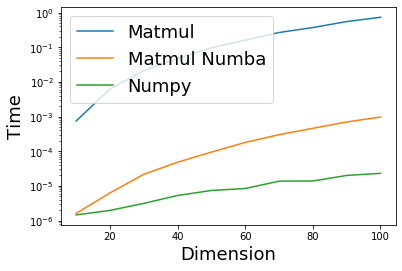

In [11]:
plt.plot(dim_range, time_range_matmul, label="Matmul")
plt.plot(dim_range, time_range_numba_matmul, label="Matmul Numba")
plt.plot(dim_range, time_range_np, label="Numpy")
plt.legend(fontsize=18)
plt.xlabel("Dimension", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.yscale("log")

## Why is na&iuml;ve implementation slow?
It is slow due to two issues:

- It does not use the benefits of fast memory (cache) and in general memory architecture
- It does not use available parallelization ability (especially important for GPU) 

## Memory architecture
<img width=80% src="Memory-Hierarchy.jpg">

- Fast memory is small
- Bigger memory is slow

## Typical Memory Hierarchy Specifications

 | Memory Type | Size | Access Time | Notes |
 |------------|------|-------------|--------|
 | CPU Registers | Few KB | <1 ns | Fastest, directly accessed by CPU |
 | L1 Cache | 32-64 KB | 1-4 ns | Split into instruction and data cache |
 | L2 Cache | 256 KB - 1 MB | 4-10 ns | Unified cache |
 | L3 Cache | 2-32 MB | 10-20 ns | Shared between CPU cores |
 | Main Memory (RAM) | 8-32 GB | 100 ns | Primary system memory |
 | SSD | 256 GB - 2 TB | 10-100 μs | Fast secondary storage |
 | Hard Drive | 1-10 TB | 5-10 ms | Slowest but largest storage |

 Key observations:
 - Access time increases ~10x at each level
 - Size increases ~10-100x at each level
 - Effective use of faster memory levels is crucial for performance


## Cache Lines and Cache Coherence
 
 - Cache memory is organized into **cache lines** - fixed-size blocks (typically 64 bytes)
 - When CPU needs data, it loads entire cache line containing that data
 - This is efficient when accessing sequential memory (spatial locality)
 
 **Cache coherence** ensures that:
 - Multiple CPU cores see consistent view of memory
 - When one core modifies data, other cores are notified
 - Prevents race conditions and data inconsistency
 
 Why it matters for matrix operations:
 - Sequential access to matrix rows/columns affects cache line utilization
 - Poor cache line usage = more cache misses = slower performance
 - Multi-threaded code needs coherent caches for correctness


# GPU Memory Architecture
 
 Modern GPUs have a different memory hierarchy compared to CPUs:
 
 | Memory Type | Size | Access Time | Notes |
 |------------|------|-------------|--------|
 | Registers | ~4 MB per SM | ~1 clock | Fastest, per thread/block |
 | Shared Memory/L1 Cache | 64-256 KB per SM | ~20-30 clocks | Shared within thread block |
 | L2 Cache | 512KB - 60MB | ~200 clocks | Shared across GPU |
 | Global Memory (VRAM) | 16-80 GB | ~400-600 clocks | Main GPU memory |
 | System RAM | 8-128 GB | >1000 clocks | CPU memory, accessed via PCIe |
 
 Key differences from CPU:
 - Much more parallel access (thousands of threads)
 - Larger register file but smaller caches
 - Higher memory bandwidth but higher latency
 - Coalesced memory access critical for performance
 
 Memory access patterns:
 - Coalesced: threads in a warp access consecutive memory = fast
 - Strided/random: threads access scattered memory = slow
 - Shared memory bank conflicts can limit bandwidth
 
 Best practices:
 - Use shared memory for frequently accessed data
 - Ensure coalesced global memory access
 - Minimize data transfer between CPU and GPU
 
 Note: The latest NVIDIA H100 GPU can have up to 80GB of HBM3 VRAM



## Making algorithms more computationally intensive 

<font color='red'>**Implementation in NLA**</font>: use block version of algorithms. <br>

This approach is a core of **[BLAS (Basic Linear Algebra Subroutines)](http://www.netlib.org/blas/)**, written in Fortran many years ago, and still rules the computational world.

Split the matrix into blocks! For illustration consider splitting in $2 \times 2$ block matrix:

$$
   A = \begin{bmatrix}
         A_{11} & A_{12} \\
         A_{21} & A_{22}
        \end{bmatrix}, \quad B = \begin{bmatrix}
         B_{11} & B_{12} \\
         B_{21} & B_{22}
        \end{bmatrix}$$

Then,  

$$AB = \begin{bmatrix}A_{11} B_{11} + A_{12} B_{21} & A_{11} B_{12} + A_{12} B_{22} \\
            A_{21} B_{11} + A_{22} B_{21} & A_{21} B_{12} + A_{22} B_{22}\end{bmatrix}.$$  

If $A_{11}, B_{11}$ and their product fit into the cache memory (which is 20 Mb (L3) for the [recent Intel Chip](https://en.wikipedia.org/wiki/List_of_Intel_processors#Desktop_(codenamed_%22Comet_Lake%22))), then we load them only once into the memory.  

## BLAS
BLAS has three levels:
1. BLAS-1, operations like $c = a + b$
2. BLAS-2, operations like matrix-by-vector product
3. BLAS-3, matrix-by-matrix product

What is the principal differences between them?

The main difference is the number of operations vs. the number of input data!

1. BLAS-1: $\mathcal{O}(n)$ data, $\mathcal{O}(n)$ operations
2. BLAS-2: $\mathcal{O}(n^2)$ data, $\mathcal{O}(n^2)$ operations
3. BLAS-3: $\mathcal{O}(n^2)$ data, $\mathcal{O}(n^3)$ operations

## Why BLAS is so important and actual?

1. The state-of-the-art implementation of the basic linear algebra operations
2. Provides standard names for operations in any new implementations (e.g. [ATLAS](https://www.netlib.org/atlas/), [OpenBLAS](https://www.openblas.net/), [MKL](https://software.intel.com/en-us/mkl)). You can call matrix-by-matrix multiplication function (GEMM), link your code with any BLAS implementation and it will work correctly
3. Formulate new algorithms in terms of BLAS operations
4. There are wrappers for the most popular languages

## Packages related to BLAS
 
1. [ATLAS](http://math-atlas.sourceforge.net) - Automatic Tuned Linear Algebra Software. It automatically adapts to a particular system architechture. 
2. [LAPACK](http://www.netlib.org/lapack/) - Linear Algebra Package. It provides high-level linear algebra operations (e.g. matrix factorizations), which are based on calls of BLAS subroutines.
3. [Intel MKL](https://software.intel.com/en-us/intel-mkl) - Math Kernel Library. It provides re-implementation of BLAS and LAPACK, optimized for Intel processors. Available in Anaconda Python distribution: 
 ```
 conda install mkl
 ```
 
4. OpenBLAS is an optimized BLAS library based on [GotoBLAS](https://en.wikipedia.org/wiki/GotoBLAS). 
 
5. PyTorch [supports](https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations) some calls from BLAS and LAPACK
6. For NVIDIA GPUs, [cuBLAS](https://docs.nvidia.com/cuda/cublas/index.html) provides a GPU-accelerated implementation of BLAS.
 
7. For AMD GPUs, [rocBLAS](https://rocmdocs.amd.com/en/latest/ROCm_Libraries/ROCm_Libraries.html#rocblas) is part of the ROCm platform and offers a BLAS implementation optimized for AMD hardware.
 
For comparison of OpenBLAS and Intel MKL, see this [review](https://software.intel.com/en-us/articles/performance-comparison-of-openblas-and-intel-math-kernel-library-in-r)
 


## Faster algorithms for matrix multiplication

Recall that matrix-matrix multiplication costs $\mathcal{O}(n^3)$ operations.
However, storage is $\mathcal{O}(n^2)$.

**Question:** is it possible to reduce number operations down to $\mathcal{O}(n^2)$?

**Answer**: a quest for $\mathcal{O}(n^2)$ matrix-by-matrix multiplication algorithm is not yet done.

* Strassen gives $\mathcal{O}(n^{2.807\dots})$ –– sometimes used in practice 

* [Current world record](http://arxiv.org/pdf/1401.7714v1.pdf) $\mathcal{O}(n^{2.37\dots})$ –– big constant, not practical, based on [Coppersmith-Winograd_algorithm](https://en.wikipedia.org/wiki/Coppersmith%E2%80%93Winograd_algorithm).
- It improved the previous record (Williams 2012) by $3\cdot 10^{-7}$
- The papers still study multiplication of $3 \times 3$ matrices and interpret it from different sides ([Heule, et. al. 2019](https://arxiv.org/pdf/1905.10192.pdf)) 

Consider Strassen in more details. 

## Na&iuml;ve multiplication

Let $A$ and $B$ be two $2\times 2$ matrices. Na&iuml;ve multiplication $C = AB$

$$
\begin{bmatrix} c_{11} & c_{12} \\ c_{21} & c_{22}  \end{bmatrix}  =
\begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22}  \end{bmatrix}
\begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22}  \end{bmatrix} =
\begin{bmatrix} 
a_{11}b_{11} + a_{12}b_{21} & a_{11}b_{21} + a_{12}b_{22} \\ 
a_{21}b_{11} + a_{22}b_{21} & a_{21}b_{21} + a_{22}b_{22} 
\end{bmatrix}
$$

contains $8$ multiplications and $4$ additions.

## Strassen algorithm

In the work [Gaussian elimination is not optimal](http://link.springer.com/article/10.1007%2FBF02165411?LI=true) (1969) Strassen found that one can calculate $C$ using 18 additions and only 7 multiplications:
$$
\begin{split}
c_{11} &= f_1 + f_4 - f_5 + f_7, \\
c_{12} &= f_3 + f_5, \\
c_{21} &= f_2 + f_4, \\
c_{22} &= f_1 - f_2 + f_3 + f_6,
\end{split}
$$
where
$$
\begin{split}
f_1 &= (a_{11} + a_{22}) (b_{11} + b_{22}), \\
f_2 &= (a_{21} + a_{22}) b_{11}, \\
f_3 &= a_{11} (b_{12} - b_{22}), \\
f_4 &= a_{22} (b_{21} - b_{11}), \\
f_5 &= (a_{11} + a_{12}) b_{22}, \\
f_6 &= (a_{21} - a_{11}) (b_{11} + b_{12}), \\
f_7 &= (a_{12} - a_{22}) (b_{21} + b_{22}).
\end{split}
$$

Fortunately, these formulas hold even if $a_{ij}$ and $b_{ij}$, $i,j=1,2$ are block matrices.

Thus, Strassen algorithm looks as follows. 
- First of all we <font color='red'>split</font> matrices $A$ and $B$ of sizes $n\times n$, $n=2^d$ <font color='red'> into 4 blocks</font> of size $\frac{n}{2}\times \frac{n}{2}$
- Then we <font color='red'>calculate multiplications</font> in the described formulas <font color='red'>recursively</font>

This leads us again to the **divide and conquer** idea.

## Example of Strassen algorithm
 
 Let's multiply two 2x2 matrices using Strassen's method:
 
$$A = \begin{bmatrix} 2 & 3 \\ 4 & 1 \end{bmatrix}, \quad B = \begin{bmatrix} 5 & 7 \\ 6 & 8 \end{bmatrix}$$
 
Calculate the 7 products $f_1$ through $f_7$:

$$\begin{align*}
f_1 &= (2 + 1)(5 + 8) = 3 \cdot 13 = 39 \\
f_2 &= (4 + 1)(5) = 5 \cdot 5 = 25 \\
f_3 &= (2)(7 - 8) = 2 \cdot (-1) = -2 \\
f_4 &= (1)(6 - 5) = 1 \cdot 1 = 1 \\
f_5 &= (2 + 3)(8) = 5 \cdot 8 = 40 \\
f_6 &= (4 - 2)(5 + 7) = 2 \cdot 12 = 24 \\
f_7 &= (3 - 1)(6 + 8) = 2 \cdot 14 = 28
\end{align*}$$
 
Now compute the elements of result matrix $C$:
 
$$\begin{align*}
c_{11} &= f_1 + f_4 - f_5 + f_7 = 39 + 1 - 40 + 28 = 28 \\
c_{12} &= f_3 + f_5 = -2 + 40 = 38 \\
c_{21} &= f_2 + f_4 = 25 + 1 = 26 \\
c_{22} &= f_1 - f_2 + f_3 + f_6 = 39 - 25 - 2 + 24 = 36
\end{align*}$$
 
Therefore:
 
$$C = \begin{bmatrix} 28 & 38 \\ 26 & 36 \end{bmatrix}$$
 
You can verify this equals the result of standard matrix multiplication!


## Complexity of the Strassen algorithm

#### Number of multiplications

Calculation of number of multiplications is a trivial task. Let us denote by $M(n)$ number of multiplications used to multiply 2 matrices of sizes $n\times n$ using the divide and conquer concept.
Then for na&iuml;ve algorithm we have number of multiplications

$$ M_\text{naive}(n) = 8 M_\text{naive}\left(\frac{n}{2} \right) = 8^2 M_\text{naive}\left(\frac{n}{4} \right)
= \dots = 8^{d-1} M(2) = 8^{d} M(1) = 8^{d} = 8^{\log_2 n} = n^{\log_2 8} = n^3 $$

So, even when using divide and coquer idea we can not be better than $n^3$.

Let us calculate number of multiplications for the Strassen algorithm:

$$ M_\text{strassen}(n) = 7 M_\text{strassen}\left(\frac{n}{2} \right) = 7^2 M_\text{strassen}\left(\frac{n}{4} \right)
= \dots = 7^{d-1} M(1) = 7^{d} = 7^{\log_2 n} = n^{\log_2 7} $$

#### Number of additions

There is no point to estimate number of addtitions $A(n)$ for naive algorithm, as we already got $n^3$ multiplications.  
For the Strassen algorithm we have:

$$ A_\text{strassen}(n) = 7 A_\text{strassen}\left( \frac{n}{2} \right) + 18 \left( \frac{n}{2} \right)^2 $$

since on the first level we have to add $\frac{n}{2}\times \frac{n}{2}$ matrices 18 times and then go deeper for each of the 7 multiplications. Thus,

<font size=2.0>

$$ \begin{split}
A_\text{strassen}(n) =& 7 A_\text{strassen}\left( \frac{n}{2} \right) + 18 \left( \frac{n}{2} \right)^2 = 7 \left(7 A_\text{strassen}\left( \frac{n}{4} \right) + 18 \left( \frac{n}{4} \right)^2 \right) + 18 \left( \frac{n}{2} \right)^2 =
7^2 A_\text{strassen}\left( \frac{n}{4} \right) + 7\cdot 18 \left( \frac{n}{4} \right)^2 +  18 \left( \frac{n}{2} \right)^2 = \\
=& \dots = 18 \sum_{k=1}^d 7^{k-1} \left( \frac{n}{2^k} \right)^2 = \frac{18}{4} n^2 \sum_{k=1}^d \left(\frac{7}{4} \right)^{k-1} = \frac{18}{4} n^2 \frac{\left(\frac{7}{4} \right)^d - 1}{\frac{7}{4} - 1} = 6 n^2 \left( \left(\frac{7}{4} \right)^d - 1\right) \leqslant 6 n^2 \left(\frac{7}{4} \right)^d = 6 n^{\log_2 7}
\end{split}
$$
</font>

(since $4^d = n^2$ and $7^d = n^{\log_2 7}$).


Asymptotic behavior of $A(n)$ could be also found from the [master theorem](https://en.wikipedia.org/wiki/Master_theorem).

#### Total complexity

Total complexity is $M_\text{strassen}(n) + A_\text{strassen}(n)=$ <font color='red'>$7 n^{\log_2 7}$</font>. Strassen algorithm becomes faster
when

\begin{align*}
2n^3 &> 7 n^{\log_2 7}, \\
n &> 667,
\end{align*}

so it is not a good idea to get to the bottom level of recursion.

# Accelerating MM by parallelization

Historically, parallel implementations of many optimized **BLAS** libraries rely on so-called **bulk synchronous programming model**:
* Static work allocation and data distribution
* Alternating parallel and communication regions to satisfy data dependencies:
    * Parallel execution
    * Data communications
    * Parallel execution
    * Data communications
    * ...

# Task-based programming model

* Another parallel programming paradigm, which requires total reimplementation of all known algotihms
* Entire algorithm is presented as a Directed Acyclic Graph (DAG) of asynchronously executed tasks
* Each node of the DAG is a task, that operates on data:
    * Incoming edge: input data
    * Outgoing edge: output data (if the task changes data)
* Special library (e.g. StarPU, PaRSEC or OpenMP) keeps track of all data and executes tasks with satisfied dependencies
* Total hardware utilization is increased due to overlapped tasks executions and data communications. Therefore, wall execution time is reduced in many cases.

# DAG of tasks for a single Mixer layer: order of execution is a runtime decision
<img width=400% src="out6.png">

# DAG of tasks for a single Mixer layer: order of execution is a runtime decision
<img width=100% src="out6_1.png">

# StarPU library: sequential task-based programming model for distributed-memory systems

## Typical workflow with the StarPU library requires only master thread to run user code:
1. Init StarPU and all other related libraries (e.g., MPI, cuBLAS).
2. Register data with StarPU.
3. Submit tasks, that operate on registered data, into a pool of tasks. Tasks are inserted asynchronously, i.e., master thread continues sequential flow through the program without waiting for the result.
4. Wait for all tasks to complete.
5. Unregister data and free memory.
6. Deinit StarPU and all related libraries (opposite to the initialization order).

# StarPU library: sequential task-based programming model for distributed-memory systems
​
​
## All the rest is done by StarPU automatically:
* Task executing workers for each core/device are created. StarPU supports CPU, CUDA, OpenCL and FPGA. Such a support can be extended via certain driver routines.
* Data communicating worker is created in case of MPI environment. StarPU supports HPC-oriented communication library NewMadeleine https://gitlab.inria.fr/pm2/pm2.
* Task is executed only when all the required input data are on the executing node.
* Performance of each low-level kernel is tracked during runtime, while communication speed between different NUMA nodes of a single computer is probed at initialization time (if needed). It helps StarPU to schedule all tasks to reduce wall execution time.
* Certain schedulers support work stealing from neighbour nodes.
* Resilient distributed computing through asynchronous checkpointing


## Strassen algorithm and tensor rank (advanced topic)

- It is not clear how Strassen found these formulas. 
- However, now we can see that they are not artificial.
- There is a general approach based on the so-called tensor decomposition technique. 
- Here by tensor we imply a multidimensional array - generalization of the matrix concept to many dimensions.

Let us enumerate elements in the $2\times 2$ matrices as follows

$$
\begin{bmatrix} c_{1} & c_{3} \\ c_{2} & c_{4}  \end{bmatrix} =
\begin{bmatrix} a_{1} & a_{3} \\ a_{2} & a_{4}  \end{bmatrix}
\begin{bmatrix} b_{1} & b_{3} \\ b_{2} & b_{4}  \end{bmatrix}=
\begin{bmatrix} 
a_{1}b_{1} + a_{3}b_{2} & a_{1}b_{3} + a_{3}b_{4} \\ 
a_{2}b_{1} + a_{4}b_{2} & a_{2}b_{3} + a_{4}b_{4} 
\end{bmatrix}
$$

This can be written as

$$ c_k = \sum_{i=1}^4 \sum_{j=1}^4 x_{ijk} a_i b_j, \quad k=1,2,3,4 $$

$x_{ijk}$ is a 3-dimensional array, that consists of zeros and ones:

$$
\begin{split}
x_{\ :,\ :,\ 1} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 2} = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix} \\
x_{\ :,\ :,\ 3} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 4} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{split}
$$



#### Trilinear decomposition

To get Strassen algorithm we should do the following trick –– decompose $x_{ijk}$ in the following way

$$ x_{ijk} = \sum_{\alpha=1}^r u_{i\alpha} v_{j\alpha} w_{k\alpha}. $$

This decomposition is called **trilinear tensor decomposition** and has a meaning of separation of variables: we have a sum of $r$ (called rank) summands with separated $i$, $j$ and $k$.

#### Strassen via trilinear

Now we have

$$ c_k = \sum_{\alpha=1}^r w_{k\alpha} \left(\sum_{i=1}^4  u_{i\alpha} a_i \right) \left( \sum_{j=1}^4 v_{j\alpha} b_j\right), \quad k=1,2,3,4. $$

Multiplications by $u_{i\alpha}$ or $v_{j\alpha}$ or $w_{k\alpha}$ do not require recursion since $u, v$ and $w$ are known precomputed matrices. Therefore, we have only $r$ multiplications of $\left(\sum_{i=1}^4  u_{i\alpha} a_i \right)$ $\left( \sum_{j=1}^4 v_{j\alpha} b_j\right)$ where both factors depend on the input data.
 
As you might guess array $x_{ijk}$ has rank $r=7$, which leads us to $7$ multiplications and to the Strassen algorithm!

## AlphaTensor

Recent [AlphaTensor](https://www.deepmind.com/blog/discovering-novel-algorithms-with-alphatensor) paper has shown how modern deep reinforcement learning can be used to get new decompositions of tensors.




# Visualization
<img width=100% src="sasha-slide-1.png">

# RL interpretation


In reinforcement learning agent learns to make **actions** based on the state and reward.

In this case, the state is the tensor.

The action is subtraction of a rank-one tensor.

If you get non-zero in the end, you get the reward.


Then, you do millions of different actions, and reinforce good results.

## Selected results

- Better ranks for certain matrix sizes

- New variants for 4x4 Strassen that work on real hardware faster (but only for this specific hardware!)

- Better antisymmetric matrix-by-vector product

## Summary of MM part
- MM is the core of NLA. You have to think in block terms, if you want high efficiency
- This is all about computer memory hierarchy
- Concept of block algorithms
- (Advanced topic) Strassen and trilinear form